# Import Libraries

In [79]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV

import xgboost

import pickle as pkl

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [155]:
## Recursive Feature Elimination with Cross-Validation
def rfecv(estimator, X, y, step, cv):
    rfecv = RFECV(estimator=estimator, 
                  step=step, 
                  cv=KFold(cv, 
                           shuffle=True, 
                           random_state=42),
                  scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    return rfecv

## Plotting % of Correct Classification
def plot_pcc(rfecv, title):
    
    plt.figure(figsize=(10, 9))
    plt.title(title, 
              fontsize=18, 
              fontweight='bold', 
              pad=20)
    plt.xlabel('Number of features selected', 
               fontsize=14, 
               labelpad=20)
    plt.ylabel('% Correct Classification', 
               fontsize=14, 
               labelpad=20)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             color='#303F9F', 
             linewidth=3)
    
    plt.show()

## Plotting feature importances
def feature_importance(rfecv, X, title): 
        
    df = pd.DataFrame()
    
    df['column'] = X.columns
    df['importance'] = rfecv.estimator_.feature_importances_
    
    df.sort_values(by='importance', 
                   ascending=False, 
                   inplace=True, 
                   ignore_index=True)
    
    sns.set(rc = {'figure.figsize':(8,10)})
    ax = sns.barplot(y='column', 
                     x='importance',
                     data=df,
                     palette='viridis')
    
    ax.set_title(title, 
                 fontsize=18)

## Predicting validation data
def pred_val(df, columns, sc, model):

    scaled_df = sc.transform(df)
    
    scaled_df = pd.DataFrame(scaled_df, 
                             columns=df.columns)
    
    scaled_df = scaled_df[columns]

    y_pred = model.predict(scaled_df)

    return y_pred

## Evaluate the final model
def eval_model(y, y_pred, title):
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r_squared = r2_score(y, y_pred)

    print(f'{title}')
    print(f'Mean Squared Error: {np.round(mse, 2)}')
    print(f'Root Mean Squared Error: {np.round(rmse, 2)}')
    print(f'Mean Absolute Error: {np.round(mae, 2)}')
    print(f'R-squared Error: {np.round(r_squared, 2)}')

# Load Data

In [3]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [4]:
str_sed_data = pd.read_csv(data_path + '/new_Kodangal_gcM.csv')

In [5]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,w,u,toposheet,in_,f,te,tl,hg,cd,cluster
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,5.819375,...,0.991997,1.811020,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0,3
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,5.819375,...,0.943758,2.203597,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0,3
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910000,...,1.682294,2.711943,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0,1
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430000,...,1.803219,2.982200,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0,1
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990000,...,1.451395,3.249200,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0,1


# EDA

In [6]:
rem_elem = []
for col in str_sed_data.columns:
    if (str_sed_data[col] == 0).all():
        rem_elem.append(col)
print(f"Elements which don't contribute in the sediment composition: {rem_elem}")

Elements which don't contribute in the sediment composition: []


In [7]:
str_sed_data.drop(rem_elem, axis=1, inplace=True)

In [8]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,w,u,toposheet,in_,f,te,tl,hg,cd,cluster
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,5.819375,...,0.991997,1.811020,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0,3
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,5.819375,...,0.943758,2.203597,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0,3
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910000,...,1.682294,2.711943,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0,1
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430000,...,1.803219,2.982200,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0,1
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990000,...,1.451395,3.249200,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0,1


In [9]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet', 
                   'cluster']:
        str_elem.append(col)

In [10]:
len(str_elem)

62

In [11]:
elem_df = str_sed_data[str_elem]
elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,44.750,9.414,3.312,0.543,5.819375,1.573,0.073,0.152,1.258,0.129,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,45.129,9.853,3.748,0.580,5.819375,1.480,0.109,0.167,1.207,0.080,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,58.283,12.534,7.768,1.321,2.910000,1.912,0.192,0.050,0.800,0.061,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,61.180,11.670,8.340,1.420,2.430000,1.710,0.180,0.250,0.660,0.080,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,60.300,11.470,8.270,1.430,1.990000,1.610,0.170,0.230,0.580,0.060,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


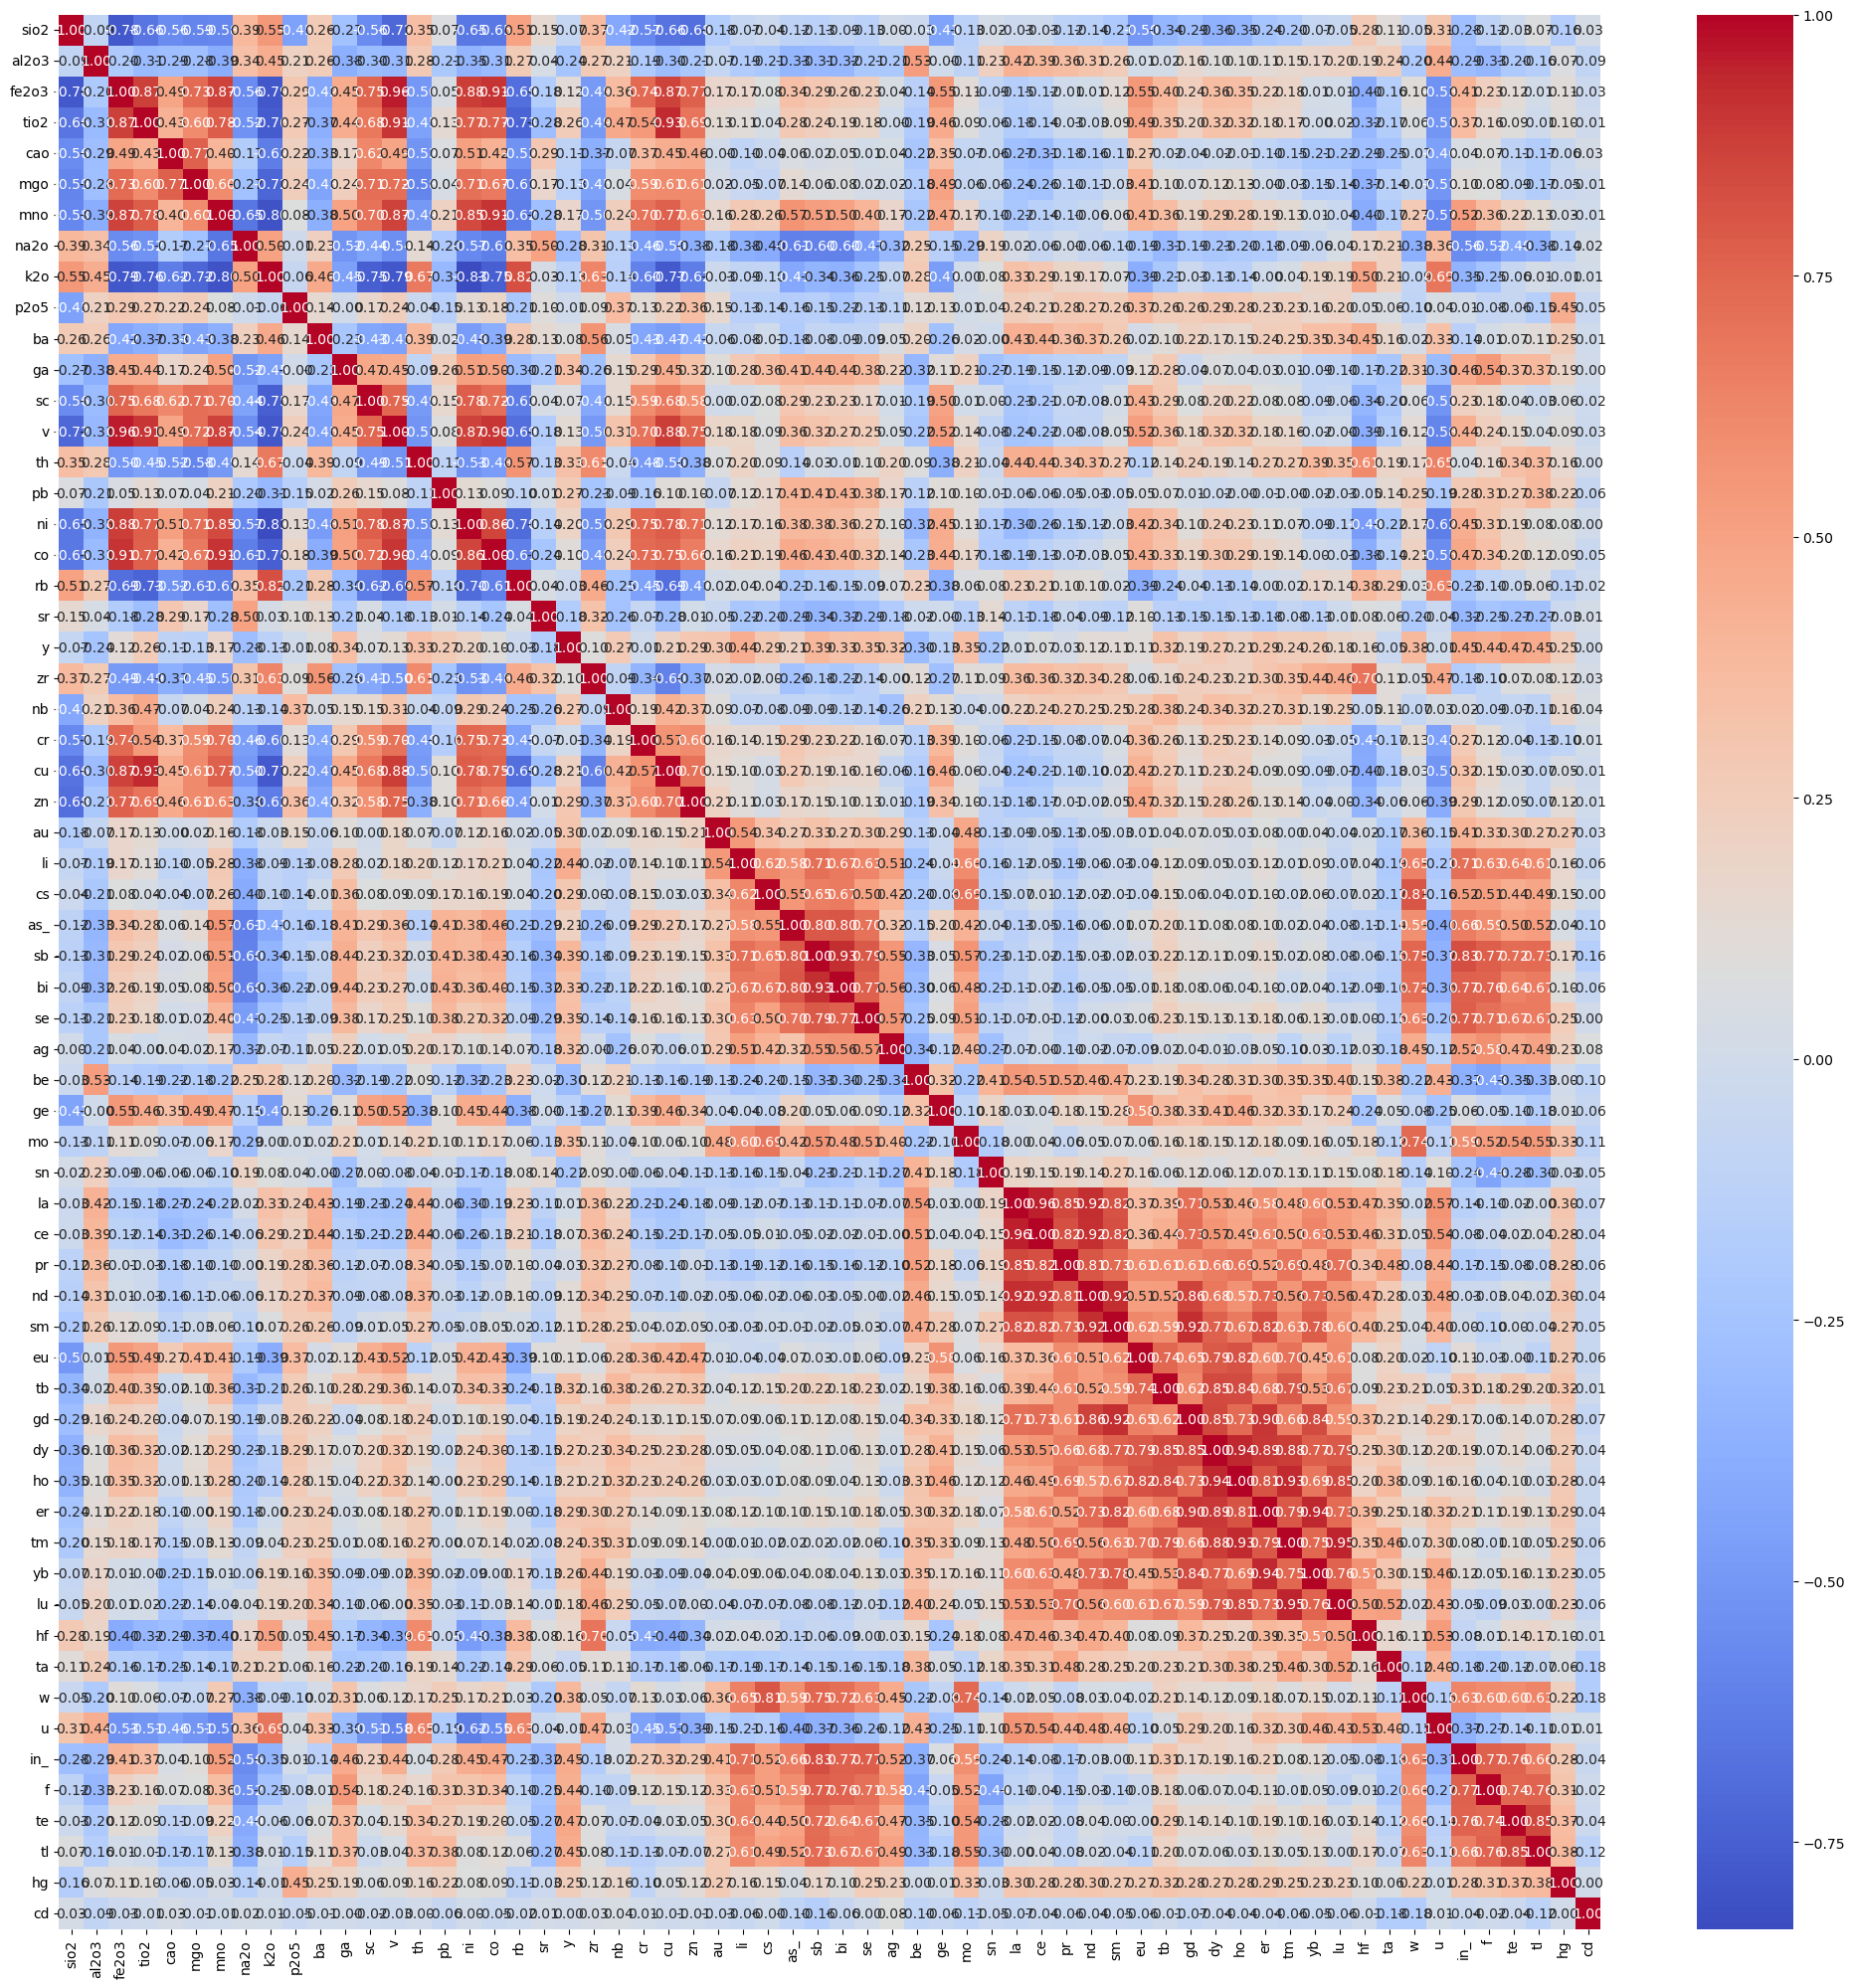

In [12]:
plt.figure(figsize=(25,25))
sns.heatmap(elem_df.corr(), 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')
plt.show()

### Histogram plots

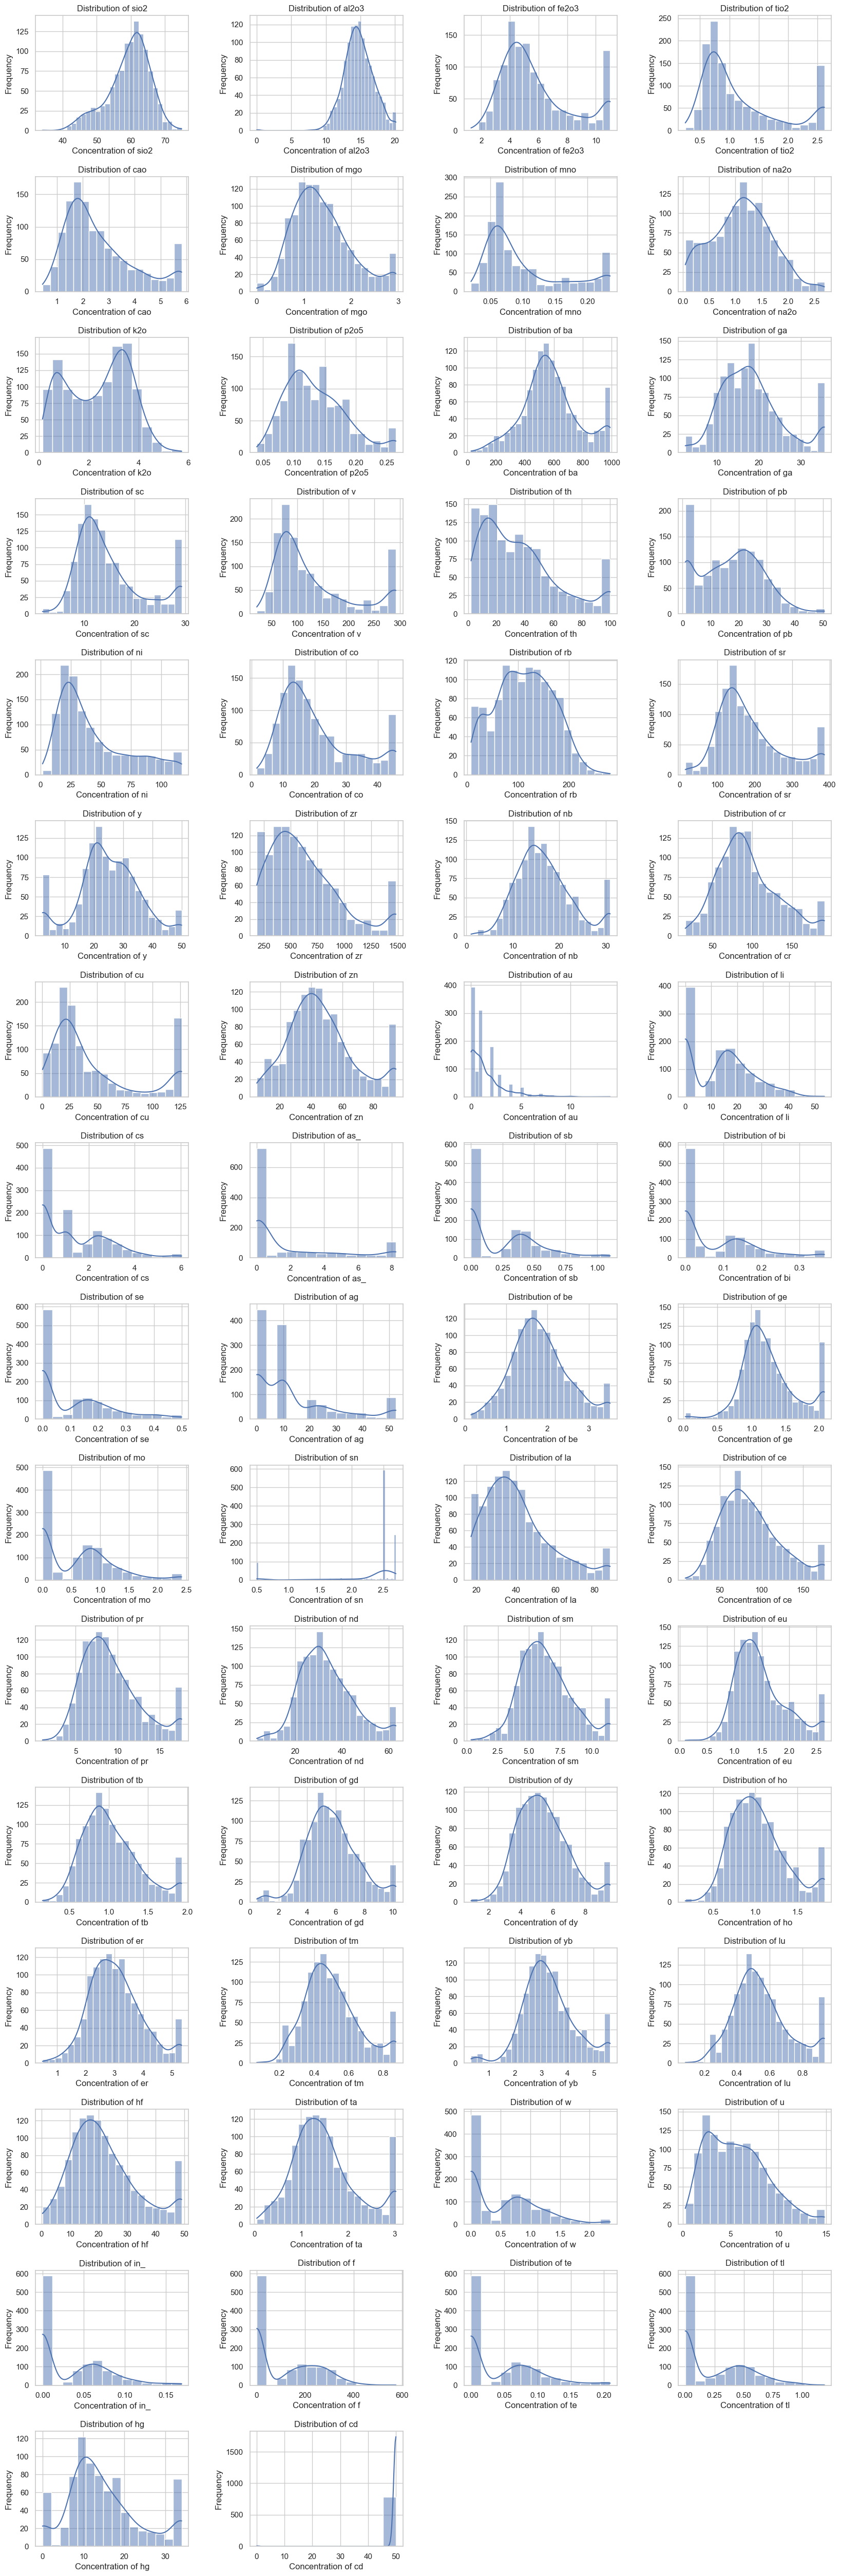

In [13]:
num_elem = len(str_elem)
num_cols = 4
num_rows = (num_elem + num_cols - 1)//num_cols 

sns.set(style='whitegrid')

fig, axes = plt.subplots(num_rows, 
                         num_cols, 
                         figsize=(num_cols*5, num_rows*4))

fig.subplots_adjust(hspace=0.4, 
                    wspace=0.4)

for i, elem in enumerate(str_elem):

    ax = axes[i // num_cols, i % num_cols]  # Determine the position in the grid
    sns.histplot(elem_df[elem], 
                 kde=True, 
                 ax=ax)
    ax.set_title(f'Distribution of {elem}')
    ax.set_xlabel(f'Concentration of {elem}')
    ax.set_ylabel('Frequency')

# If there are any empty subplots in the grid, hide them
for j in range(i + 1, num_rows * num_cols):
    axes[j // num_cols, j % num_cols].axis('off')

plt.show()

## Boxplots

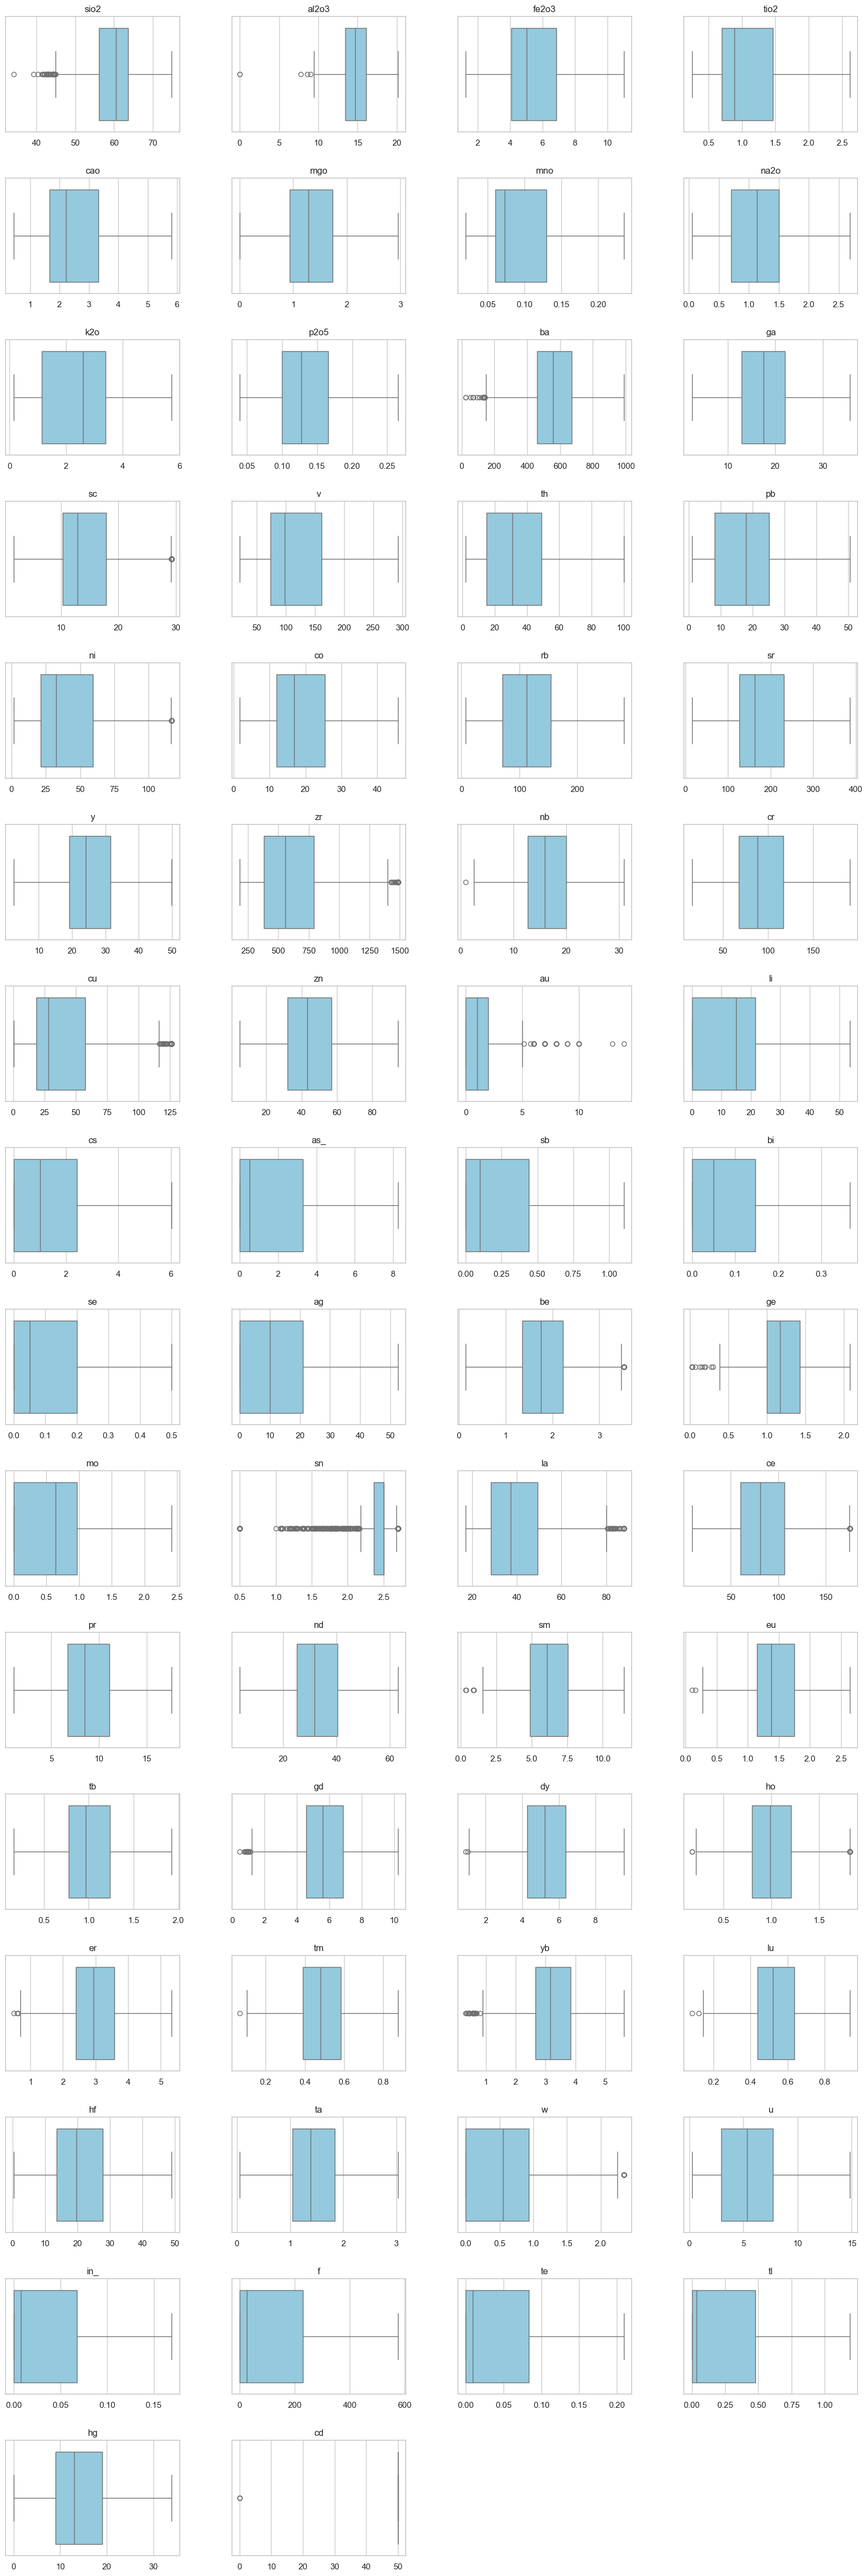

In [15]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_elem, axes.flatten())):
    sns.boxplot(x=elem_df[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

# PCA

## Split into train, validation and test data

In [12]:
(elem_df.isna()).any()

sio2     False
al2o3    False
fe2o3    False
tio2     False
cao      False
         ...  
f        False
te       False
tl       False
hg        True
cd        True
Length: 62, dtype: bool

In [13]:
elem_df['cd'] = elem_df['cd'].fillna(0)
elem_df['hg'] = elem_df['hg'].fillna(0)

In [14]:
train_df = elem_df.copy()
target = elem_df['au']
train_df.drop(['au'], axis=1, inplace=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    target, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  shuffle=True)

## Normalize

In [17]:
sc = StandardScaler()

norm_data = sc.fit_transform(X_train)

X_train_norm = pd.DataFrame(norm_data, 
                            index=X_train.index, 
                            columns=X_train.columns)

In [46]:
pca = PCA(n_components=10)
pca.fit(X_train_norm)

PCA(n_components=10)

In [51]:
total_variance = sum(pca.explained_variance_)
desired_variance = 0.75
cumulative_variance = 0
num_comp = 0

for explained_variance_ in pca.explained_variance_:
    cumulative_variance += explained_variance_
    if cumulative_variance / total_variance >= desired_variance:
        break
    num_comp += 1

print(f"Number of components to explain atleast {desired_variance*100}% of variance: {num_comp}")

Number of components to explain atleast 75.0% of variance: 2


In [48]:
pca.explained_variance_ratio_

array([0.258722  , 0.19645649, 0.1665847 , 0.03631396, 0.03460555,
       0.0301636 , 0.02709064, 0.02235168, 0.01814329, 0.01656117])

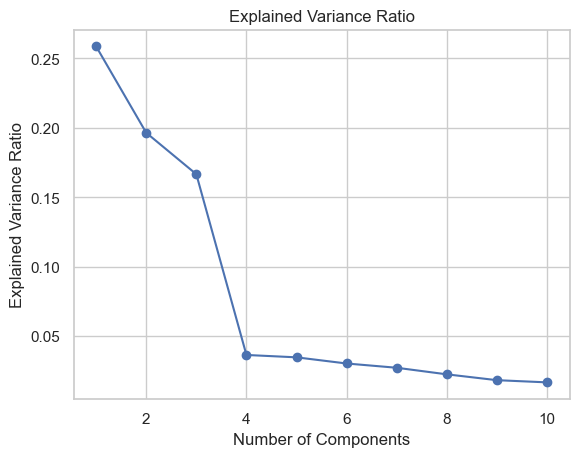

In [52]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_, 
         marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio')
plt.show()

## Fit and Transform using PCA on elements

In [53]:
pca = PCA(n_components=3)
pca_X_train = pca.fit_transform(X_train_norm)

In [54]:
pca_X_train_df = pd.DataFrame(pca_X_train, columns=['PC1', 'PC2', 'PC3'])
pca_X_train_df.head()

,PC1,PC2,PC3
0,-4.085577,-1.664847,1.943077
1,2.079484,-1.665211,6.223883
2,-2.380640,-5.119474,1.114081
3,-1.050454,5.347252,-3.626525
4,-3.189386,8.674076,3.566262


# Featue Selection

## Estimator: Random Forest Regressor

In [108]:
rf = RandomForestRegressor(n_jobs=-1)
rfecv_rf = rfecv(rf, X_train_norm, y_train, 1, 5)

In [109]:
print('Optimal number of features: {}'.format(rfecv_rf.n_features_))

Optimal number of features: 31


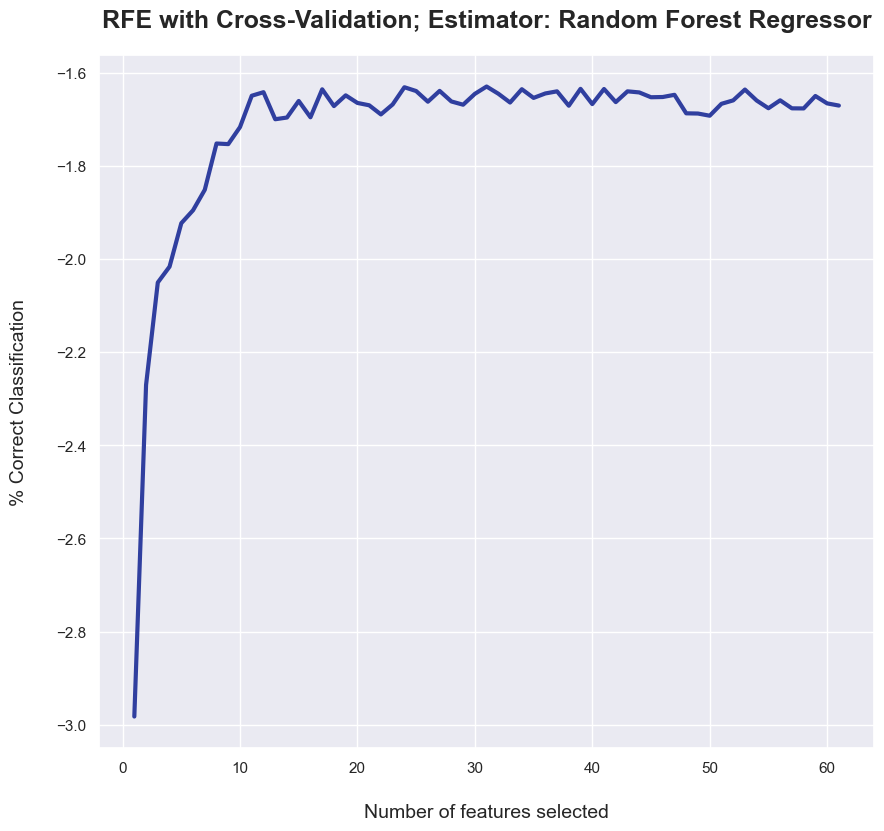

In [113]:
plot_pcc(rfecv_rf, 'RFE with Cross-Validation; Estimator: Random Forest Regressor')

In [167]:
X_rf = X_train_norm.drop(X_train_norm.columns[np.where(rfecv_rf.support_ == False)[0]], axis=1)

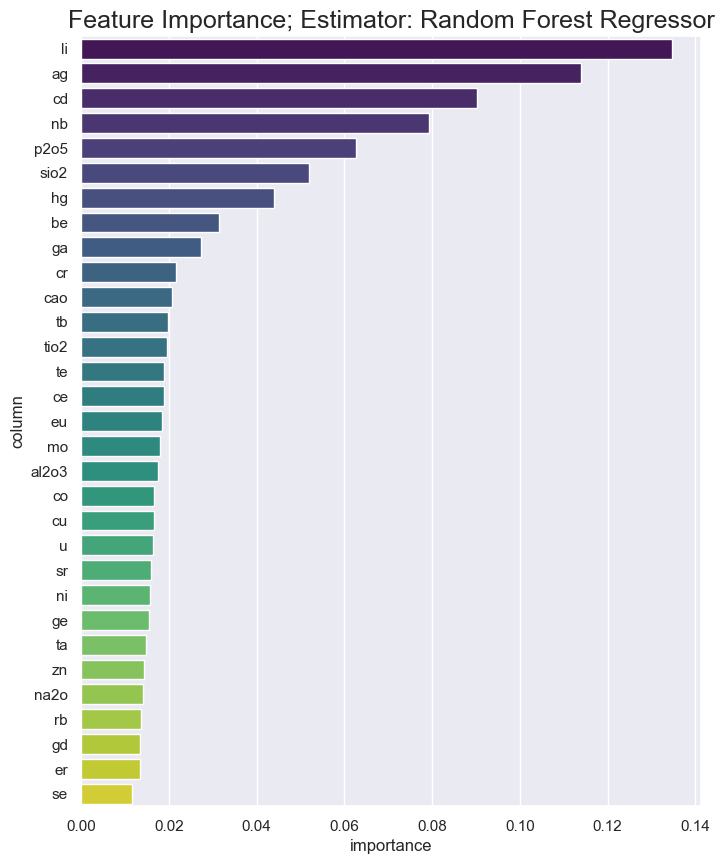

In [168]:
feature_importance(rfecv_rf, X_rf, 'Feature Importance; Estimator: Random Forest Regressor')

In [169]:
X_rf = X_rf[['li', 'ag', 'cd', 'nb', 'p2o5', 'sio2', 'hg', 'be', 'ga']]

## Estimator: Gradient Boosting Regressor

In [137]:
gbr = GradientBoostingRegressor()
rfecv_bgr = rfecv(gbr, X_train_norm, y_train, 1, 5)

In [138]:
print('Optimal number of features: {}'.format(rfecv_bgr.n_features_))

Optimal number of features: 35


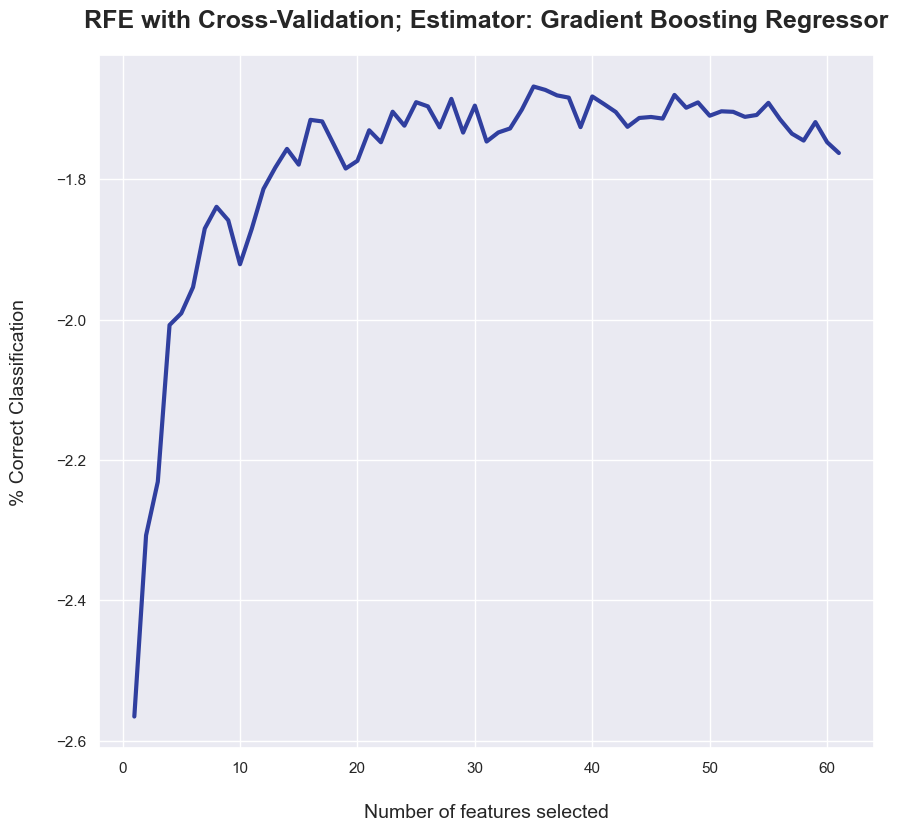

In [139]:
plot_pcc(rfecv_bgr, 'RFE with Cross-Validation; Estimator: Gradient Boosting Regressor')

In [140]:
X_gbr = X_train_norm.drop(X_train_norm.columns[np.where(rfecv_bgr.support_ == False)[0]], axis=1)

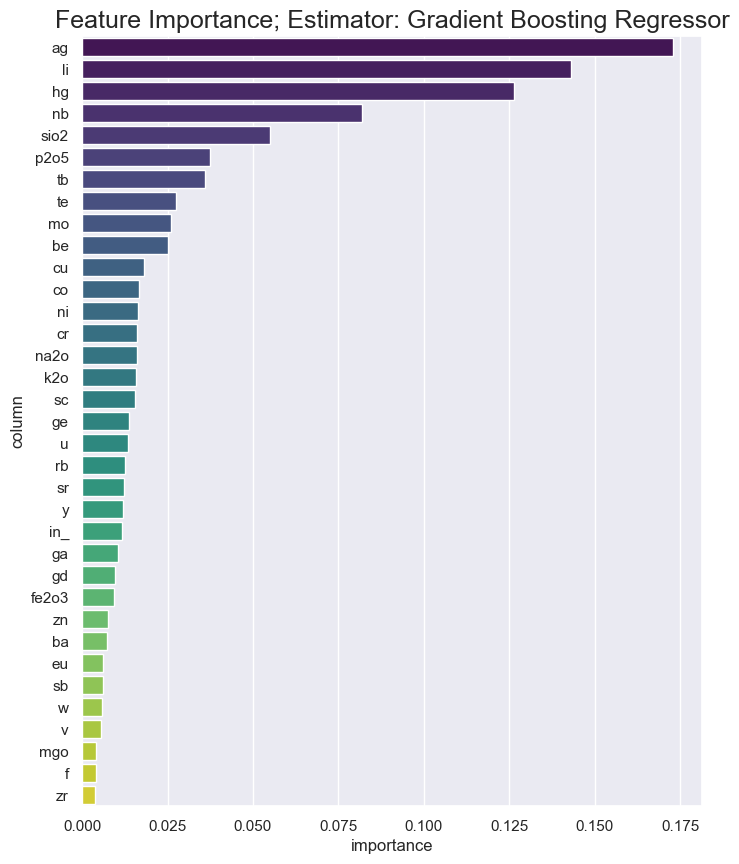

In [141]:
feature_importance(rfecv_bgr, X_gbr, 'Feature Importance; Estimator: Gradient Boosting Regressor')

In [142]:
X_gbr = X_gbr[['li', 'ag', 'hg', 'nb', 'p2o5', 'sio2', 'tb', 'te', 'mo', 'be']]

# Model Training

## Random Forest

In [75]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(pca_X_train_df, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 15, 'n_estimators': 150}


### Run the models on validation data

In [76]:
def pred_val(df, sc, pca, model):

    scaled_df = sc.transform(df)

    pca_df = pca.transform(scaled_df)

    y_pred = model.predict(pca_df)

    return y_pred

In [77]:
y_pred_val = pred_val(X_val, sc, pca, grid_search)

In [78]:
# Evaluate the final model
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_val)
r_squared = r2_score(y_val, y_pred_val)

print(f'Mean Squared Error on Validation Set: {mse}')
print(f'Root Mean Squared Error on Validation Set: {rmse}')
print(f'Mean Absolute Error on Validation Set: {mae}')
print(f'R-squared Error on Test Validation: {r_squared}')

Mean Squared Error on Validation Set: 2.6763454217763005
Root Mean Squared Error on Validation Set: 1.6359539791131963
Mean Absolute Error on Validation Set: 0.9675349837634316
R-squared Error on Test Validation: 0.25872675226744435


### Run the model on test data

In [79]:
y_pred = pred_val(X_test, sc, pca, grid_search)

In [80]:
# Evaluate the final model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error on Validation Set: {mse}')
print(f'Root Mean Squared Error on Validation Set: {rmse}')
print(f'Mean Absolute Error on Validation Set: {mae}')
print(f'R-squared Error on Test Validation: {r_squared}')

Mean Squared Error on Validation Set: 2.153012468360774
Root Mean Squared Error on Validation Set: 1.4673147134683733
Mean Absolute Error on Validation Set: 0.9239180117676932
R-squared Error on Test Validation: 0.2859754084370475


### Feeding original outlier handled data

In [108]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_train_norm, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150}


### Run the models on validation data

In [111]:
def pred_val(df, sc, model):

    scaled_df = sc.transform(df)

    #pca_df = pca.transform(scaled_df)

    y_pred = model.predict(scaled_df)

    return y_pred

In [112]:
y_pred_val = pred_val(X_val, sc, grid_search)

In [113]:
# Evaluate the final model
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_val)
r_squared = r2_score(y_val, y_pred_val)

print(f'Mean Squared Error on Validation Set: {mse}')
print(f'Root Mean Squared Error on Validation Set: {rmse}')
print(f'Mean Absolute Error on Validation Set: {mae}')
print(f'R-squared Error on Test Validation: {r_squared}')

Mean Squared Error on Validation Set: 1.7986879380072864
Root Mean Squared Error on Validation Set: 1.3411517207263637
Mean Absolute Error on Validation Set: 0.7079464725526046
R-squared Error on Test Validation: 0.5018134659990541


### Run the model on test data

In [114]:
y_pred = pred_val(X_test, sc, grid_search)

In [115]:
# Evaluate the final model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error on Validation Set: {mse}')
print(f'Root Mean Squared Error on Validation Set: {rmse}')
print(f'Mean Absolute Error on Validation Set: {mae}')
print(f'R-squared Error on Test Validation: {r_squared}')

Mean Squared Error on Validation Set: 1.3722849736030116
Root Mean Squared Error on Validation Set: 1.1714456767614159
Mean Absolute Error on Validation Set: 0.7021262022660327
R-squared Error on Test Validation: 0.5448957067439159


### After applying feature selection technique

- Estimator: Random Forest Regressor

In [170]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_rf, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}


### Run the models on validation data

In [171]:
y_pred_val = pred_val(X_val, list(X_rf.columns), sc, grid_search)

In [172]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 1.66
Root Mean Squared Error: 1.29
Mean Absolute Error: 0.66
R-squared Error: 0.54


### Run the model on test data

In [173]:
y_pred = pred_val(X_test, list(X_rf.columns), sc, grid_search)

In [174]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 1.3
Root Mean Squared Error: 1.14
Mean Absolute Error: 0.66
R-squared Error: 0.57


- Estimator: Gradient Boosting

In [143]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_gbr, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}


### Run the models on validation data

In [144]:
y_pred_val = pred_val(X_val, list(X_gbr.columns), sc, grid_search)

In [145]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 1.73
Root Mean Squared Error: 1.31
Mean Absolute Error: 0.68
R-squared Error: 0.52


### Run the model on test data

In [146]:
y_pred = pred_val(X_test, list(X_gbr.columns), sc, grid_search)

In [147]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 1.26
Root Mean Squared Error: 1.12
Mean Absolute Error: 0.63
R-squared Error: 0.58


## XGBoost

In [100]:
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of trees
    'learning_rate': [0.01, 0.1],  # Learning rate (eta)
    'max_depth': [3, 5, 7],          # Maximum depth of trees
    'colsample_bytree': [0.5, 0.7, 1.0], # Fraction of columns to be randomly sampled for each tree
    #'subsample': [0.5, 0.7, 1.0],        # Subsample ratio of the training instances (prevents overfitting)
    'gamma': [0, 0.1, 0.2],              # Minimum loss reduction required to make a further partition on a leaf node of the tree
    #'reg_alpha': [0, 0.1, 0.5, 1],       # L1 regularization term on weights (alpha)
    'reg_lambda': [1, 1.5, 2]            # L2 regularization term on weights (lambda)
}

xgb = xgboost.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(xgb, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_train_norm, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 2}


### Run the model on validation data

In [103]:
def pred_val(df, sc, model):

    scaled_df = sc.transform(df)

    #pca_df = pca.transform(scaled_df)

    y_pred = model.predict(scaled_df)

    return y_pred

In [104]:
y_pred_val = pred_val(X_val, sc, grid_search)

In [105]:
# Evaluate the final model
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_val)
r_squared = r2_score(y_val, y_pred_val)

print(f'Mean Squared Error on Validation Set: {mse}')
print(f'Root Mean Squared Error on Validation Set: {rmse}')
print(f'Mean Absolute Error on Validation Set: {mae}')
print(f'R-squared Error on Test Validation: {r_squared}')

Mean Squared Error on Validation Set: 1.6275870699295931
Root Mean Squared Error on Validation Set: 1.2757692071568403
Mean Absolute Error on Validation Set: 0.7081281639951861
R-squared Error on Test Validation: 0.549203647826044


### Run the model on test data

In [106]:
y_pred = pred_val(X_test, sc, grid_search)

In [107]:
# Evaluate the final model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error on Validation Set: {mse}')
print(f'Root Mean Squared Error on Validation Set: {rmse}')
print(f'Mean Absolute Error on Validation Set: {mae}')
print(f'R-squared Error on Test Validation: {r_squared}')

Mean Squared Error on Validation Set: 1.2408712367731256
Root Mean Squared Error on Validation Set: 1.113944000734833
Mean Absolute Error on Validation Set: 0.6760874224069008
R-squared Error on Test Validation: 0.5884777301388668


### After applying feature selection technique

- Estimator: Random Forest Regressor

In [131]:
param_grid = {
    'n_estimators': [100, 200, 300],    
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],          
    'colsample_bytree': [0.5, 0.7, 1.0], 
    #'subsample': [0.5, 0.7, 1.0],        
    'gamma': [0.1, 0.2],             
    #'reg_alpha': [0, 0.1, 0.5, 1],       
    'reg_lambda': [1, 1.5, 2],           
    'objective': ['reg:squarederror']
}

xgb = xgboost.XGBRegressor()

grid_search = GridSearchCV(xgb, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_rf, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'objective': 'reg:squarederror', 'reg_lambda': 2}


### Run the model on validation data

In [132]:
y_pred_val = pred_val(X_val, list(X_rf.columns), sc, grid_search)

In [133]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 1.82
Root Mean Squared Error: 1.35
Mean Absolute Error: 0.72
R-squared Error: 0.5


### Run the model on test data

In [134]:
y_pred = pred_val(X_test, list(X_rf.columns), sc, grid_search)

In [136]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 1.27
Root Mean Squared Error: 1.13
Mean Absolute Error: 0.65
R-squared Error: 0.58


- Estimator: Gradient Boosting

In [148]:
param_grid = {
    'n_estimators': [100, 200, 300],    
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],          
    'colsample_bytree': [0.5, 0.7, 1.0], 
    #'subsample': [0.5, 0.7, 1.0],        
    'gamma': [0.1, 0.2],             
    #'reg_alpha': [0, 0.1, 0.5, 1],       
    'reg_lambda': [1, 1.5, 2],           
    'objective': ['reg:squarederror']
}

xgb = xgboost.XGBRegressor()

grid_search = GridSearchCV(xgb, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=5, 
                           n_jobs=-1)

grid_search.fit(X_gbr, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'objective': 'reg:squarederror', 'reg_lambda': 2}


In [150]:
### Run the model on validation data

In [151]:
y_pred_val = pred_val(X_val, list(X_gbr.columns), sc, grid_search)

In [152]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 1.78
Root Mean Squared Error: 1.33
Mean Absolute Error: 0.73
R-squared Error: 0.51


### Run the model on test data

In [153]:
y_pred = pred_val(X_test, list(X_gbr.columns), sc, grid_search)

In [159]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 1.27
Root Mean Squared Error: 1.13
Mean Absolute Error: 0.65
R-squared Error: 0.58
